# Notebook 00 : Total time running BuildJet per month under lf-edge repository

Scope of this notebook is to calculate total minutes used by BuildJet runners. 
This notebook provides step by step calculation with each assumption on which calculation
was based.

If you want to run it, you should install requirements.txt

In [55]:
DATA_CACHED = True

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add the parent directory to sys.path
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


# .env file should contain GHA_TOKEN variable which
# is access token for GitHub (generated per user)
from dotenv import load_dotenv

from src.gha import GitHubActionsAPI, GitHubWorkflowStat, duration_time

In [3]:
load_dotenv()

True

### Step 1: determening workflows using specific runners

**Assumption 1:** only `lf-edge/eve` and `lf-edge/eden` are using BuildJet runners

**Assumption 2:** within `lf-edge/eve` only `build.yml`, `buildondemand.yml` and `eden.yml` are using BuildJet  

**Assumption 3:** within `lf-edge/eden` only `test.yml` and `eden.yml` is using BuildJet runners

This can be easily checked by running 

```bash
grep -nirl "buildjet" .github
```

for each lf-edge repository

### Step 2: calculating time spent on each workflow from GitHub API

GitHub provides REST API to access workflow information, some of this information is also seen on web page.
Full description of available endpoints and data schema can be found [here](https://docs.github.com/en/rest/actions/workflow-runs?apiVersion=2022-11-28), so that leads us to

**Assumption 4:** We can get all the runs from GitHub by calling `https://api.github.com/lf-edge/{eve,eden}/actions/runs`

Although, GitHub does not provide detailed description we can find multiple fields of interest: `created_at`, `updated_at`, `run_started_at`. Latter resets every re-run, each re-run is its own entity linked through other fields, therefore 

**Assumption 5:** Duration of a run can be calculated as `updated_at` - `run_started_at`

Based on Assumptions 1-5 `GitHubActionsAPI` and `GitHubWorkflowStat` classes in gha module of src package calculate following total number of minutes for each workflow:

**Note:** Skip this step if you want to use cached data

In [ ]:
from ipywidgets import IntProgress
from IPython.display import display
import math

In [5]:
# Downloading and filtering only workflows, this might take time
# progress bar is for convinience :)

if not DATA_CACHED:
    base_url = "https://api.github.com"
    org = "lf-edge"
    repo = "eve"
    access_token = os.getenv("GHA_TOKEN")
    
    gha = GitHubActionsAPI(base_url, org, repo, access_token)
    
    per_page = 100 # maximum for GitHub API
    pages = gha.page_count(per_page)
    eden_workflows = []
    
    f = IntProgress(min=1, max=pages) # instantiate the bar
    display(f) # display the bar
    
    for i in range(1, pages+1):
        workflows = gha.load_workflows(i, per_page)
        for workflow in workflows:
            wfs = ['.github/workflows/eden.yml', '.github/workflows/build.yml', '.github/workflows/buildondemand.yml']
            if any(wf in workflow['path'] for wf in wfs):
                eden_workflows.append(workflow)
    
        f.value += 1
    
    print(f"In total we have {len(eden_workflows)} workflows")
    
    for wf in eden_workflows:
        wf['duration'] = math.ceil(duration_time(wf).seconds / 60)
    
    wf_stat = GitHubWorkflowStat(eden_workflows)
    ## Cache data to save time for future runs :)
    wf_stat.save("../data/intermediate/eve_workflows.json")

IntProgress(value=1, max=234, min=1)

In total we have 8265 workflows


In [17]:
# Doing same action only for eden repository
if not DATA_CACHED:
    base_url = "https://api.github.com"
    org = "lf-edge"
    repo = "eden"
    access_token = os.getenv("GHA_TOKEN")
    
    gha = GitHubActionsAPI(base_url, org, repo, access_token)
    
    per_page = 100 # maximum for GitHub API
    pages = gha.page_count(per_page)
    eden_workflows = []
    
    f = IntProgress(min=1, max=pages) # instantiate the bar
    display(f) # display the bar
    
    for i in range(1, pages+1):
        workflows = gha.load_workflows(i, per_page)
        for workflow in workflows:
            wfs = ['.github/workflows/test.yml', '.github/workflows/eden.yml']
            if any(wf in workflow['path'] for wf in wfs):
                eden_workflows.append(workflow)
    
        f.value += 1
    
    print(f"In total we have {len(eden_workflows)} workflows")
    
    for wf in eden_workflows:
        wf['duration'] = math.ceil(duration_time(wf).seconds / 60)
    
    wf_eden_stat = GitHubWorkflowStat(eden_workflows)
    ## Cache data to save time for future runs :)
    wf_eden_stat.save("../data/intermediate/eden_workflows.json")

IntProgress(value=1, max=26, min=1)

In total we have 501 workflows


### Step 3: Combining workflows together as pandas DataFrame

**Assumption 6:** skipped workflwos do not add to used time

In [49]:
import pandas as pd

In [52]:
# Run this step if you have and want to use cached data

if DATA_CACHED:
    wf_eden_stat = GitHubWorkflowStat(None)
    wf_eden_stat.load("../data/intermediate/eden_workflows.json")
    
    wf_stat = GitHubWorkflowStat(None)
    wf_stat.load("../data/intermediate/eve_workflows.json")

In [25]:
fields = ['conclusion', 'run_attempt', 'duration', 'created_at']

df1 = pd.DataFrame(wf_stat.pick(fields), columns=fields)
df1['repo'] = 'EVE'
df2 = pd.DataFrame(wf_eden_stat.pick(fields), columns=fields)
df2['repo'] = 'Eden'
df = pd.concat([df1, df2], axis=0)

df.created_at = pd.to_datetime(df.created_at)
df['year'] = df.created_at.dt.year
df['month'] = df.created_at.dt.month
# skipped workflows do not add to used time
actual_workflows = df[df.conclusion != 'skipped']

actual_workflows['year'] = actual_workflows.created_at.dt.year
actual_workflows['month'] = actual_workflows.created_at.dt.month
actual_workflows['day'] = actual_workflows.created_at.dt.day
actual_workflows['qtr'] = actual_workflows.created_at.dt.quarter

/tmp/ipykernel_29660/1060244116.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_workflows['year'] = actual_workflows.created_at.dt.year
/tmp/ipykernel_29660/1060244116.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_workflows['month'] = actual_workflows.created_at.dt.month
/tmp/ipykernel_29660/1060244116.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

## Step 4: Calculating time spent totall in minutes monthly

In [20]:
import seaborn as sns

[Text(0, 0.5, 'duration (min)')]

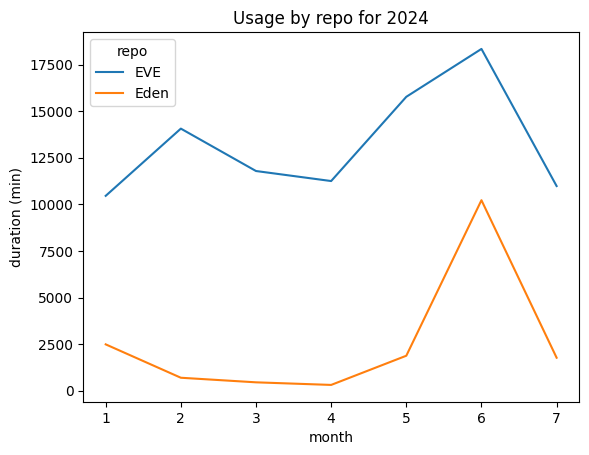

In [47]:
grouped = actual_workflows.groupby(['repo', 'year', 'month'])['duration'].sum().reset_index()
fig = sns.lineplot(data=grouped[grouped.year == 2024], x='month', y='duration', hue='repo')

fig.set_title("Usage by repo for 2024")
fig.set(ylabel='duration (min)')

Now let's see total duration by repo by year and quarter in a table

In [27]:
actual_workflows.groupby(['repo', 'year', 'qtr'])['duration'].sum()

repo  year  qtr
EVE   2023  2      151635
            3      164427
            4      113868
      2024  1       36307
            2       45359
            3       10982
Eden  2023  2       17354
            3       18615
            4       22479
      2024  1        3633
            2       12410
            3        1771
Name: duration, dtype: int64

Same, but now for each month of the year

In [28]:
actual_workflows.groupby(['repo', 'year', 'month'])['duration'].sum()

repo  year  month
EVE   2023  5        113675
            6         37960
            7         70069
            8         62144
            9         32214
            10        31222
            11        74144
            12         8502
      2024  1         10456
            2         14063
            3         11788
            4         11250
            5         15770
            6         18339
            7         10982
Eden  2023  5          5723
            6         11631
            7         11118
            8          4010
            9          3487
            10        12884
            11         8377
            12         1218
      2024  1          2487
            2           696
            3           450
            4           311
            5          1877
            6         10222
            7          1771
Name: duration, dtype: int64

### Extra: calculate running time for a specific timeframe

In [23]:
from datetime import date

from_mask = df.created_at.dt.date >= date(year=2024,month=6,day=30)
to_mask = df.created_at.dt.date <= date(year=2024, month=7, day=31)

actual_running_time = df[from_mask & to_mask].duration.sum()

print(actual_running_time)

12946
